## **Step 01: Install easyfsl**
### EasyFSL typically refers to "Easy Few-Shot Learning," which is a framework or toolkit designed for few-shot learning (FSL)

In [1]:
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 1.9 MB/s eta 0:00:00


## **Step 02: Import necessary libraries**

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## **Step 03: Loading and Transforming the Omniglot Dataset**
### In this section, we prepare the Omniglot dataset for training and testing by applying a series of transformations to the images.

In [3]:
image_size = 28


train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 9464212/9464212 [00:00<00:00, 88714183.15it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


100%|██████████| 6462886/6462886 [00:00<00:00, 103774332.93it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


## **Step 04: Implementing Prototypical Networks**
### In this section, we implement Prototypical Networks, a type of metric-based learning model designed for few-shot learning tasks. These networks compare query examples to support examples to classify the query based on distances in the embedding space.

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Step 05: Setting Up Evaluation Tasks for Few-Shot Learning**
### In this section, we define and prepare the evaluation tasks for few-shot learning. We use a task sampler to create tasks with a specified number of classes, support images, and query images.

In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Step 06: Visualizing Support and Query Images**
### In this section, we visualize examples of support and query images from one of the evaluation tasks. This helps us understand the data that the model will process during the few-shot learning tasks.

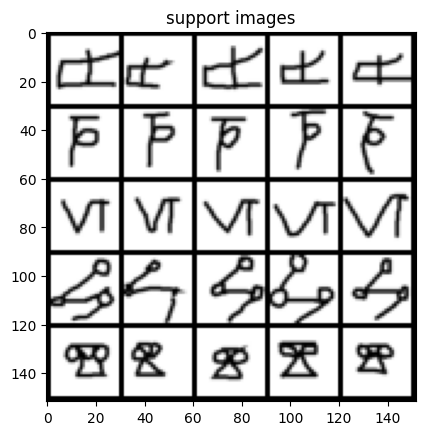

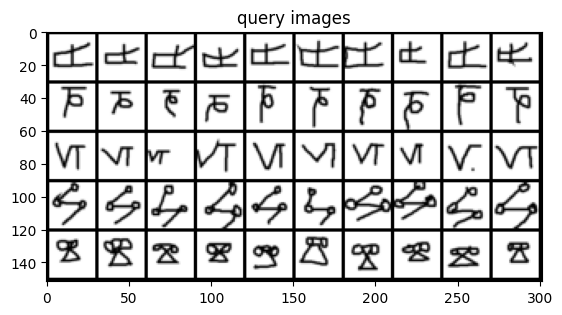

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## **Step 07: Evaluating the Model on an Example Task**
### In this section, we evaluate the Prototypical Networks model on an example task from the evaluation set. We compute the predicted labels for the query images and compare them with the ground truth labels.

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Glagolitic/character11
Aurek-Besh/character06 / Aurek-Besh/character06
Aurek-Besh/character06 / Glagolitic/character11
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Glagolitic/character11
Tibetan/character14 / Tibetan/character14
Tibetan/character14 / Tibetan/character14
Aurek-Besh/character05 / Aurek-Besh/character06
Aurek-Besh/character05 /

## **Step 08:  Evaluating the Model on Multiple Tasks**
### In this section, we define and use functions to evaluate the Prototypical Networks model on multiple tasks. This involves computing the model's accuracy over the entire test set.

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:

    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:05<00:00, 19.14it/s]

Model tested on 100 tasks. Accuracy: 85.76%


## **Step 09: Setting Up Training Data and Sampler for Episodic Training**
### In this section, we prepare the training data and define a sampler to create few-shot learning tasks for training the Prototypical Networks model.

In [ ]:
N_TRAINING_EPISODES = 3000
N_VALIDATION_TASKS = 100

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct.
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

## **Step 10: Setting Up Loss Function and Optimizer**
### Defining the Loss Function (Cross Entropy Loss) and Optimizer (Adam)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

## **Step 11: Training Loop with Logging**

In [ ]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 3000/3000 [03:44<00:00, 13.39it/s, loss=0.647]


 ## **Step 12: Evaluate the performance of the Prototypical Networks model on the test dataset**

In [ ]:
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 22.01it/s]

Model tested on 100 tasks. Accuracy: 91.88%
